# Clase 7 Data transformation - refuerzo

### Variables categoricas
El astype category es para datos categoricos pero hay que prepararlos con antelacion si se trata de una variable **categorica ordinal**

```python
# Crea un tipo de variable categorica ordinal
cat_dtype = pd.types.CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday'],ordered = True)

# Convierte el tipo de dato a categorico
df.weekday = data.weekday.astype(cat_dtype)
```

- Cuando se trata de una variable categorica no ordinal: `df.Sexo = df.Sexo.astype('category')`

-----
### Describe()

**describe()** por defecto no incluye objetos, con el parametro **include= 'O'** los incluye.
`df.describe(include = 'O') # incluye en el describe el tipo object`

-----

### Estandarizacion de datos para mejorar la consistencia.

Supongase que se encuentre la fusion de dos dataframes y pero en la categoria sexo se encuentran valores como **Hombre, Mujer, Masculino Femenino**, es buena practica usar map para cambiar los valores a unos valores mas estandar

```python
Crea un diccionario para el mapa
sexo_dict = {
	'Mujer':'Femenino',
	'F':'Femenino',
	'Femenino':'Femenino',
	'Hombre':'Masculino',
	'M':'Masculino',
	'H':'Masculino',

}
# Cambia el calor de la columna sexo con la funcion map y el diccionario
df.Sexo = df.Sexo.map(sexo_dict)
# Asegurese que no haya errores
df.Sexo.unique()
```
### Separando dataframes por tipo de dato

```python
cat_data = df.select_dtypes(include=['object']).copy()
cat_data.info()
```

----

### One hot encoding
Crea n columnas poniendo el valor 0 o 1, representando booleanos, esto se hace porque algunas librerias no soportan valores categoricos.

1. Usando Pandas
para el caso de sexo se verá **Masculino, Femenino, Sin informacion**

```python
Esto creará 3 columnas nuevas ['Masculino','Femenino','Sin_Informacion'] con valores 0 o 1
df.Sexo.cat.codes # codifica la columna Sexo
df['SexoCat'] = data.Sexo.cat.codes

## Este es el resultado
df_envoding = pd.get_dummies(data, columns=['Sexo']).head()
```
2. Usando Sklearn

```python
from skalearn.preprocessing import OneHotEncoder()

x = df['Sexo'].to_numpy().reshape(-1,1)
enc = OneHotEncoder()
enc.fit(x)
enc.transform(x).toarray()

# para consultar
enc.inverse_transform([[1,0,0],[0,1,0],[0,0,1],])

# 
enc.get_featured_names(['Gender'])
```
### Label Encoding

Suponga que un se cuenta con una variable categorica ordinal, O si se cuenta con una variable categorica no ordinal muy grande como marcas de gaseosas, para evitar la creacion masiva de columnas, se usa mejor un **Label Encoding**, que dota de valores o ID las variables categoricas.

```python
from sklearn.preprocessing import LabelBinarizer

jobs_encoder = LabelBinarizer()
jobs_encoder.fit(df['Sexo']) # Analiza las caractgorias
transformed = jobs_encoder.transform(df['Sexo']) # Transforma las categorias
ohe_df = pd.DataFrame(transformed)
ohe_df.head()

df = pd.concat([data, ohe_df], axis = 1)
```

## Imṕuter

# Clase 1-2, data cleaning

A continuación un **tip** para poder hacer una exploracion de los datos y que la PC no se incendie, fijese en el parametro **nrows**

```python
# Read the data file and take a look at the data
df = pd.read_csv('data/trips.csv', nrows=10000)
# nrows limita el numero filas porque el dataset es muy grande consume en espacio 1.1 GB de ram
```

### Consistencia de integridad

Se piensa juntar dos datasets, pero ambas debe pivotar en una columna en comun ID, en este caso la tabla bike tiene tres columnas ID: **Start_date, end_date y bike_ID**, la idea es poder generar un ID unico, por lo que se procede a **concatenar estas columnas en un solo string** y luego proceder a codificar el **string concatenado a un string base64** y pasarlo a una nueva columna como un **nuevo ID**

```python
# Let's generate an id for each trip, in order to uniquely identify each trip. 
# The trip id can be a combination of start date, end date, and bike id
df['trip_id'] = df.apply(lambda x: ':'.join([str(x['Start Date']), str(x['End Date']), str(x['Bike Id'])]), axis=1)

# In order for the id to look actually like a unique identifier, let's use base64 encode to convert the id to a base64 string
# The command converts the newly created id column into bytes, and then gets the base64 encoded value for the same. 
# Then the base64 value is converted to string again and then stored in the trip_id column.
df['trip_id'] = df['trip_id'].apply(lambda x: base64.b64encode(x.encode()).decode())

df['trip_id'].unique()

```
-----
### Importacion usando JSON

Mientras que abrir un archivo csv es facil mediante la funcion `read_csv()` de pandas, en JSON se usa la funcion `read_json()` con un parametro adicional que le indica el sentido de las columnas `orient=`

```python
stations = pd.read_json("data/stations.json", orient="columns")
stations.head()
```

### Separando columnas usan la funcion str.split()
En este caso existe una columna con el nombre de el estado, la ciudad y la estacion, y fue separado en 3 columnas respectivamente

```python
split_columns = stations["Station Name"].str.split(pat=",", expand=True)
split_columns.head()
```

### Ejemplo de pd.concat
`stations = pd.concat([stations, split_columns], axis=1)`

----
### Explicacion de uso de strip

### Funcion Strip.
Remueve los espacios al inicio y al final del string:

```python
txt = "     banana     "
x = txt.strip()
print("of all fruits", x, "is my favorite")
```
Usted puede especificar un caracter personalizado  en la funcion strip para remover
(e.g. para remover usaria `my_series.str.strip(to_strip="_")`, y "\hello world!\" quedaria "hello world!"), 
en lugar de remover los espacios en blanco.

----

### Funcion Merge basado en el nombre de 2 columnas de cada dataframe:

Ponga atencion a los parametros de la funcion merge, una funcion merge normalmente seria:
`pd.merge(df_izq, df_der, on= 'columna en comun', how='left')`, esto sirve para cuando ambos dataframes tienen una columna con el mismo nombre y ambos valores coinciden.

Pero cuando no hay una columna en ambos dataframes con un nombre coincidente, hay que juntarlos usando columnas de nombres distintos, pero que sus valores coincidan

```python
df = pd.merge(df, stations, left_on="start_station_id", right_on="station_id", how="left")

rename_dict = {
    "latitude":"start_latitude",
    "longitude":"start_longitude",
    "station_name":"start_station_name",
    "location":"start_location"
}
df = df.rename(columns=rename_dict)
# Remove the extra column that was added
df = df.drop(columns=["station_id"])
# Fill any remaining nulls with "Not Available" - only for string columns
obj_cols = df.columns[df.dtypes=="object"]
df[obj_cols] = df[obj_cols].fillna('Not Available')
df.head()
```

## Cargar datos csv con conversion de fechas al vuelo.

Fijese en el parametro parse_dates, este convierte los strings de fechas en datetime, ahorrando un paso.

```python
# We've generated the merged df DataFrame for you, but you will have to figure out the code we used (in Exercise 5)!
df = pd.read_csv("data/df_exercise.csv", parse_dates=["start_date"])

df['start_hour'] = df['start_date'].dt.hour # dt.hour gets you the hour
df['start_weekday'] = df['start_date'].dt.weekday # dt.weekday gets you the weekday (as an integer)
```

# Exportando el dataframe limpio a csv:

Ojo con el parametro encoding, es recomendable de que siempre sea **utf-8**
`df.to_csv("clean.csv", encoding="utf-8")`

* `.csv`: archivos de valores separados por comas. Este es el formato de tabla estándar de filas y columnas que ha visto en DataFrames. Una forma común de compartir archivos `.csv` es comprimirlos como archivos `.csv.gz`, lo que reduce en gran medida su tamaño. Puedes [hacer eso](https://stackoverflow.com/a/46073397/6945498) en "pandas" con bastante facilidad.
* `.json`: archivos JSON. Son muy similares a los diccionarios de Python. Son alternativas populares a los archivos `.csv` porque normalmente consumen mucha menos memoria, pero también son menos legibles por humanos. Los cubriremos más adelante en este caso.
* `.xlsx`: Archivos Excel. En general, debe evitar el uso del formato obsoleto `.xls` de Excel ([aquí](https://www.bbc.com/news/technology-54423988) una razón).
* `.sql`: archivos SQL. Estos se pueden cargar directamente en una base de datos SQL. Estos están cubiertos en un caso diferente.

Cuando hablamos de lograr coherencia en un conjunto de datos nos referimos a lo siguiente:

1. **Coherencia del tipo de datos.** Esto se refiere a tener todas las características representadas en el tipo de datos correcto. Por lo tanto, si estás trabajando en "pandas", los números decimales deben representarse como "flotante", los enteros como "int", las cadenas como "objeto", las categorías como "categoría", etc. Otros ejemplos de coherencia de tipos de datos son convertir columnas Sí/No en booleanos ("Verdadero", "Falso"), asegurarse de que todas las fechas tengan el formato correcto y no se traten como cadenas o números, y redondear números decimales con una precisión adecuada.
     1. Además, tenga en cuenta que `pandas` no permite valores faltantes en columnas del tipo de datos `int`, por lo que si necesita tener `NaN` en su serie, deberá usar ` flotar`.
2. **Consistencia de unidades.** Si tienes características numéricas, es importante que estén en las unidades correctas. Por ejemplo, si tienes una característica en kilómetros y otra en millas, debes convertirlas a una unidad común antes de poder hacer cálculos que involucren a ambas.
3. **Coherencia categórica.** Las características que se supone que son categóricas deben estandarizarse. Por ejemplo, si su conjunto de datos tiene una categoría "bicicleta" que está representada por dos cadenas diferentes (por ejemplo, "bicicleta" y "bicicleta"), entonces debe detectar esta inconsistencia y corregirla (por ejemplo, reemplazando todas las instancias de "bicicleta" con `bicicleta`, para tener sólo una etiqueta por categoría).
4. **Formato de cadena.** A veces tendrás elementos extraños en tus cadenas, como asteriscos y otros caracteres especiales. A menudo no son útiles, por lo que es necesario eliminarlos. Otras tareas de formato de cadenas pueden incluir eliminar puntuación, poner mayúsculas, minúsculas o mayúsculas, eliminar espacios iniciales y finales, etc.
5. **Integridad referencial.** Cada observación única en su conjunto de datos debe tener una identificación única, especialmente si planea unirla con otros conjuntos de datos (en cuyo caso las identificaciones de sus observaciones deben coincidir con las claves de unión del otro conjunto de datos). . Muchas veces, esto requiere que elimine filas duplicadas y cree ID para las filas que no las tienen.
6. **Coherencia en los nombres de las columnas.** No es necesario que sea tan estricto con este como con los requisitos anteriores, pero ser coherente con la forma en que nombra las columnas es, no obstante, una buena práctica. Puede configurar todas sus columnas para que sigan un estándar de nomenclatura común, de modo que sus nombres sean significativos y sea fácil hacer referencia a ellas en el futuro.

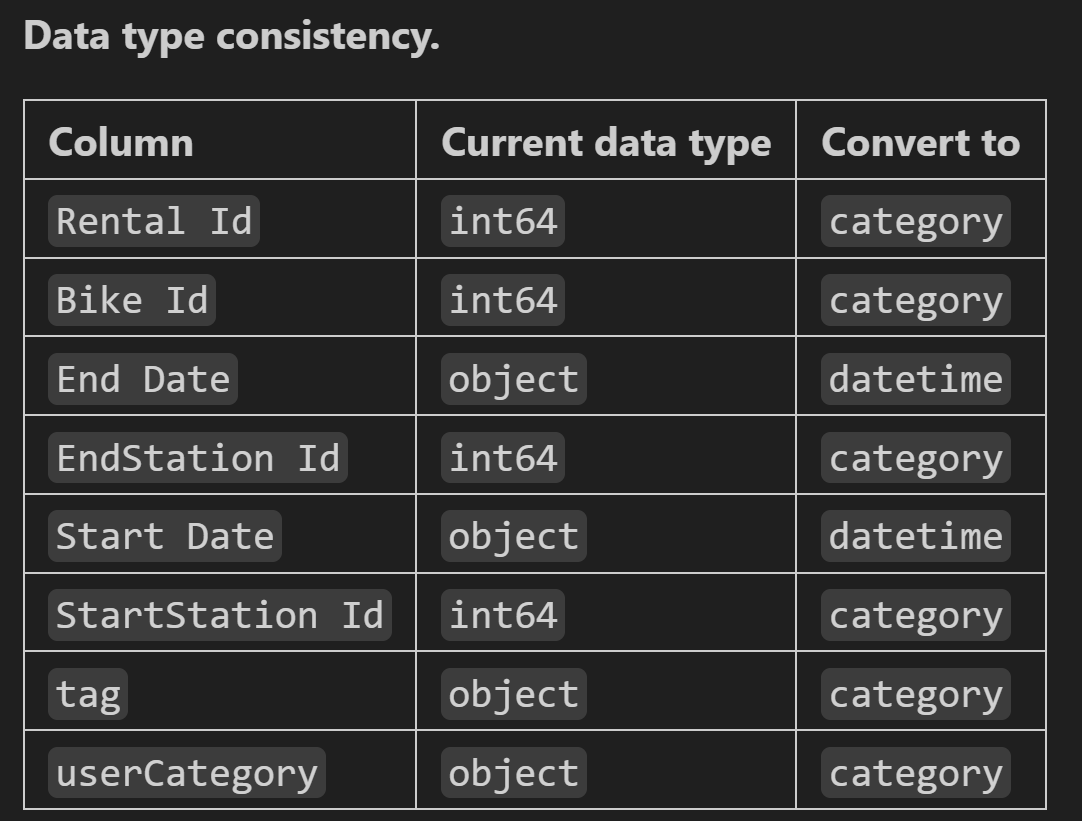

Tenga en cuenta que "StartStation Id", "EndStation Id", "Rental ID" y "Bike Id" no son números que usaremos para realizar operaciones aritméticas; Estos son ID, por lo que convertirlos en características de "categoría" parece sensato.

**Coherencia de la unidad.** Tenemos las duraciones en segundos, pero para calcular el costo por alquiler, las necesitamos en minutos.

**Coherencia categórica.** En "etiqueta" se supone que tenemos solo tres categorías, "baja", "media" y "alta", pero según nuestro informe, tenemos cinco. Una mirada más cercana a nuestro DataFrame revela que tenemos estas etiquetas: "prioridad baja", "prioridad baja", "prioridad_alta", "prioridad_media" y "prioridad media". Necesitamos estandarizarlos.

**Formato de cadena.** También vemos que `userCategory` tiene un formato extraño (es decir, `['A']` y `['B']` en lugar de `A` y `B`), que necesita ser corregido.

**Integridad referencial.** Nuestro conjunto de datos tiene filas duplicadas y no tiene ID de viaje. Necesitamos resolver estos dos problemas.

**Coherencia de los nombres de las columnas.** Los nombres de las columnas parecen estar bien en general, pero podríamos hacerlos más legibles si los pusiéramos todos en minúsculas y separaramos las palabras con guiones bajos en lugar de usar mayúsculas y minúsculas.

Garantizar que su conjunto de datos contenga sólo la información relevante implica:

1. **Eliminar características u observaciones innecesarias.** Esto depende de para qué le gustaría usar los datos a su cliente. Las columnas innecesarias podrían ser columnas que contengan la misma información que otras columnas, solo que en un tipo de datos diferente, o columnas que simplemente no agregan información interesante. Por ejemplo, las observaciones innecesarias pueden ser de años que no nos interesan (por ejemplo, "eliminar todo antes de agosto de 2013") o categorías que no son necesarias para el caso de uso (por ejemplo, "eliminar usuarios no registrados").
2. **Mantenerse en el nivel correcto de granularidad.** Si su cliente necesita los datos agregados por mes, entréguelos agregados por mes. Si lo necesitan agregado por estado en lugar de por código postal, hágalo. Sin embargo, en general, a menos que se requiera lo contrario, la recomendación es proporcionar siempre el nivel más alto de granularidad, es decir, el nivel más detallado de resolución de los datos que pueda, porque si bien puede convertir fácilmente datos desagregados en datos agregados (por ejemplo, tomando datos diarios y agrupar por meses), es imposible hacer lo contrario (convertir datos mensuales a datos diarios).
3. **Tratar adecuadamente los valores faltantes.** Hay tres estrategias básicas:
     1. Elimine las filas con valores faltantes.
     2. Elaborar estimaciones razonables de cuáles deberían ser los valores si estuvieran disponibles (esto se llama **interpolación**)
     3. Reemplácelos con un marcador de posición apropiado ("No disponible" es común para las variables de cadena, y los números 0 o -1 a veces se usan para variables numéricas)
4. **Detectar valores atípicos y tratarlos.** Manejar adecuadamente los valores atípicos es más importante en la etapa de modelado de datos que en la etapa de limpieza de datos. Aun así, al limpiar conjuntos de datos se espera que elimine (y posiblemente reemplace) los valores atípicos que son obviamente datos erróneos. Por ejemplo, mientras que en la etapa de limpieza de datos debes eliminar a una persona que recorrió 120 kilómetros en 10 minutos en su bicicleta (dato claramente erróneo), pero si en cambio recorrió esa misma distancia en un día, debes dejarlo como está porque aunque la observación sigue siendo un caso atípico, aún podría ser perfectamente válida.

**Eliminar funciones u observaciones innecesarias.** A primera vista, parece que ninguna de las funciones es redundante. Sin embargo, la "duración" está en segundos, no en minutos, por lo que debería sustituirse por otra columna como se decidió anteriormente.

**Mantenerse en el nivel correcto de granularidad.** Nuestro cliente no ha expresado ningún requisito en cuanto al nivel deseado de agregación de los datos. Deberíamos ceñirnos a la granularidad actual (granularidad máxima).

**Tratar correctamente los valores faltantes.** Estas columnas tienen muchos valores faltantes: `Bike Id` y `EndStation Id`. Tendremos que ocuparnos de esto.

**Detectar valores atípicos y tratarlos.** No detectamos muchos valores atípicos, pero eso se debe en parte a que el informe no proporciona muchos detalles. Es posible que algunos valores atípicos se vuelvan evidentes a medida que avanzamos en la limpieza, por lo que debemos estar atentos a esto.

En este caso, aprendió un marco para limpiar conjuntos de datos, que consta de cuatro componentes:

1. Asegurarse de que su salida tenga la codificación correcta y esté en el formato correcto
2. Hacer que su conjunto de datos sea coherente interna y externamente
3. Conservar sólo la información relevante
4. Aumentar sus datos con nuevos conjuntos de datos y funciones diseñadas

Como siempre, debes tener en cuenta las necesidades de los usuarios de tu salida, ya que no todas las tareas de limpieza de datos son apropiadas en todas las situaciones. No obstante, puede utilizar este marco como lista de verificación para asegurarse de no omitir nada importante.

Al limpiar datos, un problema muy común es la falta de datos. Aprendimos algunas formas de lidiar con los datos faltantes y cuándo estos métodos tienden a ser apropiados:

1. Eliminar por completo las filas con datos faltantes es una opción nuclear que solo tiene sentido cuando se tiene un caso de uso claro y muy limitado para el conjunto de datos.
2. Reemplazar los valores faltantes con un relleno sin sentido como "No encontrado" o 0 tiene sentido si necesita conservar los demás datos en esas filas pero no puede completarlos de manera sensata o no le importan particularmente los valores faltantes en esa columna específica. .
3. Interpolar los valores faltantes tiene sentido cuando necesita preservar elementos de la distribución subyacente o tendencias dentro de los datos de esa columna.

También vimos que para conjuntos de datos grandes, trabajar con un pequeño subconjunto de datos es una herramienta útil para adquirir intuición sobre el conjunto de datos e iterar rápidamente en el proceso de limpieza. No se puede enfatizar lo suficiente este elemento de recopilación de intuición; de hecho, como vio en el ejercicio 1, una gran parte del proceso de limpieza involucró elementos de análisis de datos exploratorios, mediante la generación de estadísticas resumidas.

# Clase 4 - EDA intermedio.


Asignacion de dtypes a varias columnas de golpe
`df = pd.read_csv('Chicago_crime_data.csv', dtype={'ID': object, 'beat_num': object})`

### Wordcloud

wordcloud es una libreria estetica que aumenta el tamaño de los textos dependiendo de la frecuencia de los datos categoricos.


```python

from wordcloud import WordCloud # A package that will allow us to make a wordcloud

# wordcloud for primary type defined by rank
def wordcloud_crime( df, rank ):
    df_filter = df[df["Primary Type"]==df["Primary Type"].value_counts().index[rank]]
    text = ' '.join(df_filter['Description'])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


print("Crime type: ", df["Primary Type"].value_counts().index[0])
wordcloud_crime( df, 0 )
```

### Funcion isin()

```python
df_1 = df[df["Location Description"].isin(df["Location Description"].value_counts().index[:10]) & df["Primary Type"].isin(df["Primary Type"].value_counts().index[:10])]
pd.crosstab(df_1["Primary Type"],df_1["Location Description"])
```

La función isin de Pandas se utiliza para verificar si los elementos de una serie o un DataFrame están presentes en otra serie, DataFrame o lista. Devuelve una serie booleana que indica si cada elemento está presente o no. Aquí tienes un ejemplo de cómo se usa:

```python
import pandas as pd

# Crear una serie
s = pd.Series([1, 2, 3, 4, 5])

# Verificar si los elementos están presentes en la serie
print(s.isin([2, 4, 6]))
```
```
# Salida:
# 0    False
# 1     True
# 2    False
# 3     True
# 4    False
# dtype: bool
```
En este ejemplo, isin([2, 4, 6]) verifica si los elementos 2, 4 y 6 están presentes en la serie s y devuelve una serie booleana que indica si cada elemento está presente o no. En este caso, los elementos 2 y 4 están presentes en la serie, mientras que el elemento 6 no lo está.

```python
import pandas as pd

# Crear una serie
s = pd.Series([1, 2, 3, 4, 5])

# Verificar si los elementos están presentes en la serie
print(s.isin([2, 4, 6]))
```

### Crosstab

`pd.crosstab(df_1["Primary Type"],df_1["Location Description"])`

La función pd.crosstab en pandas se utiliza para calcular una tabla de frecuencias cruzadas entre dos o más variables categóricas. Esta función es útil para analizar la relación entre diferentes variables categóricas y comprender cómo se distribuyen entre sí.

Aquí tienes un ejemplo de cómo puedes utilizar pd.crosstab:


```python
import pandas as pd

# Crear un DataFrame de ejemplo
data = {
    'Sexo': ['M', 'F', 'F', 'M', 'M', 'F'],
    'Ciudad': ['A', 'B', 'A', 'B', 'B', 'A'],
    'Edad': [25, 30, 20, 35, 40, 45]
}
df = pd.DataFrame(data)

# Calcular la tabla de frecuencias cruzadas
tabla_frecuencias = pd.crosstab(df['Sexo'], df['Ciudad'])

print(tabla_frecuencias)
```

Esto producirá la siguiente salida:

```
Ciudad  A  B
Sexo       
F       2  1
M       1  2
```

En este ejemplo, la función pd.crosstab calcula la tabla de frecuencias cruzadas entre las columnas "Sexo" y "Ciudad" del DataFrame. Muestra cuántos registros tienen cada combinación de valores de "Sexo" y "Ciudad".

### Renombrar números en categorias.

En el siguiente script se observa como usan la **variable dayofweek de un objeto datetime** que devuelve **numeros enteros del 0 al 6** correspondientes a los dias de la semana.

Luego con la funcion `cat.rename_categories()` se le pasa una **lista de strings** con los dias de la semana como parametro.

```python

df["dayofweek"] = df.date_py.dt.dayofweek.astype("category")
df.dayofweek = df.dayofweek.cat.rename_categories(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
res = df.groupby(["dayofweek"])['ID'].count().reset_index(name="count")
res['count'] = res['count']/pd.date_range("2017-1-1","2017-12-31",freq="D").dayofweek.value_counts()[::-1]
_ = res.plot(x="dayofweek", y = "count", title = "2017 crime patterns in a week")
_ = plt.ylabel("Average daily total incidents")
```

### Zfill

Zfill es una funcion de los strings que permite rellenar cadenas de texto con numeros cero al inicio de la cadena

```python
siete = '7'
print(siete.zfill(3)) # La salida será 007
```

### Branca

```python
df["dayofweek"] = df.date_py.dt.dayofweek.astype("category")
df.dayofweek = df.dayofweek.cat.rename_categories(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
res = df.groupby(["dayofweek"])['ID'].count().reset_index(name="count")
res['count'] = res['count']/pd.date_range("2017-1-1","2017-12-31",freq="D").dayofweek.value_counts()[::-1]
_ = res.plot(x="dayofweek", y = "count", title = "2017 crime patterns in a week")
_ = plt.ylabel("Average daily total incidents")
```

### Geopandas

la libreria pandas no es capas de abrir archivos geojson, geopandas es una libreria que permite manipular este tipo de archivos.


```python
import geopandas

# load the shape file for Chicago police beats
beat_orig = geopandas.read_file("Boundaries_beat.geojson", driver = "GeoJSON")
beat_data = beat_orig.join(beat_cn.set_index("beat_num"), how = "left", on = "beat_num")
beat_data.fillna(0, inplace = True)
```

### Folium

Folium es una libreria para graficar mapas.

```python
# interactive visualization for beat-specific crime rate in 2017

m_crime = folium.Map(location=[41.88, -87.63],
                        zoom_start=12,
                        tiles="OpenStreetMap")
style_function = lambda x: {
    'fillColor': colormap(x['properties']['crime_count']),
    'color': 'black',
    'weight':2,
    'fillOpacity':0.5
}

stategeo = folium.GeoJson(
    beat_data.to_json(),
    name='Chicago beats',
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['beat_num', 'crime_count'],
        aliases=['Beat', 'Total crime'], 
        localize=True
    )
).add_to(m_crime)

colormap.add_to(m_crime)
m_crime
```

### crosstab

```python
res_raw = pd.crosstab(df["Primary Type"], df.dayofweek)
res_raw/pd.date_range("2017-1-1","2017-12-31",freq="D").dayofweek.value_counts().tolist()[::-1]
```

```python
def folium_slider( beat_cn, beat_orig, tmp_drange, index_var, index_lab, 
                   value_var = "crime_count", caption = "Crimes in Chicago" ):
    # get colorbar
    min_cn, max_cn = beat_cn[value_var].quantile([0.01,0.99]).apply(round, 2)
    colormap = branca.colormap.LinearColormap(
        colors=['white','yellow','orange','red','darkred'],
        #index=beat_cn['count'].quantile([0.2,0.4,0.6,0.8]),
        vmin=min_cn,
        vmax=max_cn
    )
    colormap.caption=caption
    
    # get styledata for folium
    styledata = {}

    for beat in range(beat_orig.shape[0]):
        res_beat = beat_cn[beat_cn.beat_num==beat_orig.iloc[beat,:].beat_num]
        #fill missing value by zero: no recorded crime that month
        c_count = res_beat.set_index(index_var)[value_var].reindex(tmp_drange).fillna(0)
        df_tmp = pd.DataFrame(
            {'color': [colormap(count) for count in c_count], 'opacity':0.5},
            index = index_lab
        )
        styledata[str(beat)] = df_tmp
    
    styledict = {
        str(beat): data.to_dict(orient='index') for
        beat, data in styledata.items()
    }
    
    # plot map and time slider
    m = folium.Map(location=[41.88, -87.63],
                        zoom_start=12,
                        tiles="OpenStreetMap")

    g = TimeSliderChoropleth(
        beat_orig.to_json(),
        styledict=styledict
    ).add_to(m)

    folium.GeoJson(beat_orig.to_json(), style_function = lambda x: {
        'color': 'black',
        'weight':2,
        'fillOpacity':0
    }, tooltip=folium.GeoJsonTooltip(
            fields=['beat_num'],
            aliases=['Beat'], 
            localize=True
        )).add_to(m)

    colormap.add_to(m)
    
    return m
```

### Normalización de fechas

Se tiene un dataframe con los crimenes cometidos en el transcurso del año 2017, pero al graficar se puede observar que en febrero es la epoca cuando se cometen menos crimenes, pero esto es falso, ya que febrero tiene solo 28 dias. Para evitar que esto ocurra es necesario normalizar los meses.

1. Se procede a hacer el conteo de crimenes cometidos a traves de los meses
2. Luego se hace una lista con el total de dias que tiene cada mes.
3. Finalmente se realiza una división entre el numero de dias por mes.

```python
# cycle in a year
beat_cn_month = df.groupby(["beat_num","month"])["ID"].count().reset_index(name = "crime_count")
nd = pd.DataFrame({"month":range(1,13), "days":[31,28,31,30,31,30,31,31,30,31,30,31]})
beat_cn_month = beat_cn_month.merge(nd, how = "left", on = "month")
beat_cn_month["crime_count"] = beat_cn_month["crime_count"]/beat_cn_month["days"]
folium_slider( beat_cn_month, beat_orig, list(range(1,13)), "month",
               list(pd.date_range( "2017-1", "2017-12", freq = "MS").strftime("%Y-%m")),
               caption = "Average daily total incidents in a month")
```

# Clase 5 - Cleaning practice

Checkins es una **lista de python**, por lo tanto se puede usar la **funcion append** de las listas, **no confundir con la funcion deprecada append** de pandas.

```py
reviews = pd.read_csv('reviews.csv', nrows=1000)
businesses = pd.read_csv('businesses.csv', nrows=1000)
checkins = []
with open('checkins.json', encoding='utf-8')  as f:
    for row in f.readlines()[:1000]:
        checkins.append(json.loads(row))
checkins
```

### Ignorando lo que esta fuera del rango

En algunos trozos de código hemos visto el caracter **&** que hace las veces de **and**, esta vez es el caracter **pipe** **(|)** que equicale a **or**

Lo que hace el trozo de código es buscar las coordenadas de latitud que sean mayores a 90 o menores a -90 y las reemplaza por np.nan(), lo mismo ocurre con la longitud, esta ves con menores a -180 y mayores a 180

```py
businesses.loc[(businesses['latitude'] < -90) | (businesses['latitude'] > 90), 'latitude'] = np.nan
businesses.loc[(businesses['longitude'] < -180) | (businesses['longitude'] > 180), 'longitude'] = np.nan
```

### Ejemplo de uso de la libreria Shapely

La librería Shapely en Python es una biblioteca de manipulación y análisis de geometría. Permite realizar operaciones geométricas en objetos como puntos, líneas y polígonos. Algunas de las funcionalidades que ofrece Shapely incluyen:

Creación y manipulación de puntos, líneas y polígonos.
Cálculo de áreas, longitudes y perímetros de geometrías.
Realización de operaciones espaciales como uniones, intersecciones, diferencias y buffer.
Verificación de la validez de geometrías.
Transformación de geometrías mediante proyecciones y cambios de coordenadas.
Aquí tienes un ejemplo básico que muestra cómo usar Shapely para calcular el área de un polígono:

```py
from shapely.geometry import Polygon

# Crear un polígono con coordenadas de los vértices
poligono = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])

# Calcular el área del polígono
area = poligono.area

print(area)
# Salida: 1.0
```

En este caso, se crea un polígono con coordenadas de los vértices y luego se utiliza el método area para calcular el área del polígono. El resultado es 1.0.

### Creando puntos con Shapely, usando las coordenadas no ignoradas.

Relacionado con el trozo de código que rellena con np.nan las coordenadas de longitud y latitud.
- En este caso ignora los valores nan() y los que si tenga valores crea un punto con la libreria shapely
- Si el punto recien creado cae dentro de un poligono con la forma de algun estado EEUU, retorna las propiedades de ese punto.

```py
from shapely.geometry import Point, shape
import json

with open('us-state-shapes.json') as f:
    states = json.load(f)
    
def get_state_name(row):
    if not row['latitude'] or not row['longitude']:
        return None
    point = Point(row['longitude'], row['latitude'])
    for state in states['features']:
        polygon = shape(state['geometry'])
        if polygon.contains(point):
            return state['properties']['NAME']
        
businesses['state'] = businesses.apply(get_state_name, axis=1)
```